# **Assessment 1**

For our first assessment, our goal is to solve an imputation problem: we will create a neural network architecture that learns how to recover missing portions of an image.

This is an important problem in magnetic resonance imaging (MRI), where patient scans are often limited to a few areas to avoid lengthy scanning times.

In particular, we are going to focus on images of human heads. We have managed to gain access to one hundred images of patient's heads but, unfortunately, these images have a significant portion of missing information. Your goal during the assessment is to design a neural network that can recover these missing portions.

<br>

---

<br>

We do not have access to the labels for the images we want to recover, so we will have to be a bit creative to obtain a workable dataset on which to train our neural network.

Fortunately for us, we have access to a generative model that has been trained to produce realistic-looking MRI images of patient's heads. Using this model, you will create an appropriate dataset to train your architecture. We have provided you with the basic setup code to start using this generative model in **Question 1** below.

The corrupted images that we want to recover are contained in the numpy file `test_set.npy` of this repository. The file contains 100 patient images with a size of 64x64 pixels.

The architecture that you design in this assessment should use the artificially-generated dataset in order to recover the missing information in the images contained in `test_set.npy`.

<br>

All answers to the assessment should be contained within the structure below, but you are free to add new code and text cells as required to your answers. Read the text for each question and follow the instructions carefully. Answers that do not follow this structure will not be marked. **Do NOT change the name of this file.**

Please, **make sure to execute all your cells and save the result of the execution**. We will only mark cells that have been executed and will not execute any cells ourselves.

<br>

---

<br>

<br><br>

## **Question 1**  (25%)

Using the provided image-generation network, create a dataset of brain images that will later be used to train your chosen architecture.

Given that you will likely want to use this dataset multiple times during training, we recommend that you save the generated images to an appropriate folder in your GDrive.

Once you have generated your dataset, load and display ten of your generated images here.

We have also provided you with some corrupted images in the file `test_set.npy` of this repository. You should also load and display ten of these corrupted images here.

Below, we have provided template code, including some required downloads and installations, so that you can easily use the trained generative model. Sample generation in this model is done using the function `generate`, and is controlled by some input arguments. It is your job to figure out a sensible set of parameters that will produce images that are useful for the requirements of your task.

<br>

---
**Question 1 Answer:**

We have an inpainting image task that involves reconstructing missing regions in an image. Specifically, in our test_npy files, we have one hundred different images of human heads with regions that need to be imputed. To achieve this, we have a function called ‘generate’, which utilises a diffusion model to generate images of uncorrupted human heads. We will try to apply the same/similar mask present in the test_files.npy to these newly generated images. This will form our training dataset, which we will then use with a chosen architecture. We will delve into more details as we go on.


In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [3]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


In [4]:
def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

Cuda installed! Running on GPU 0 Tesla T4!


In [ ]:
# Pull and install necessary files
!gdown 1-6JPxY7rUySRaCXTKHD400e8UWs2DZiY # run.sh
!gdown --folder 1-PJmUzB9HN3mCKsl7qKGlUynltY5ttp7 # ese-invldm
!gdown --folder 1-V9EOGuiYOiszIg3pA15D9ThwXO1gr4E # files
!chmod +x run.sh
!bash ./run.sh
sys.path.append('/content/ese-invldm')

In [ ]:
!unzip /content/drive/MyDrive/cw1_files.zip -d ./
!chmod +x run.sh
!bash ./run.sh
sys.path.append('/content/ese-invldm')

First, let’s generate some images for the training dataset. Here, a proper balance is required for every parameter between computational cost and computational time, as we have a limited number of compute units (50).



*   The first parameter is the ***number of samples***, which significantly influences both computational cost and time. In the lectures, we used the MNIST dataset, which has 60,000 images in its training dataset. However, given the parameters used, it would take approximately 4 hours to generate all these images. Since we have a total of 29 hours available, this would account for 15% of the total time, which is excessively long and computationally expensive. Therefore, I opted to generate 15,000 samples, which seems reasonable in terms of both time and computational cost.
*   The recommended ***number of steps*** is between 10 and 50. Through my analysis, I realized that even though the pixel values of the images were not the same, they appeared visually similar. Given that I still had available compute units, I opted for 25 steps to achieve a good resolution and hopefully pleasing final output.

* Between the two options for the ***scheduler***, after a few iterations, I immediately noticed that 'ddim' resulted in better outputs.

* Regarding the ***temperature*** parameter, which controls randomness, I opted for a value of 0.5. This choice allows for the generation of diverse images, ensuring that the final model can handle various inputs. The test set contains visually distinct images; however, we did not want to set the temperature too high because it could lead to excessive randomness, resulting in images that are too varied and less coherent.


In [282]:
from ese_invldm import generate

"""
Generates samples using a diffusion-based generative model.

This function leverages a pre-configured diffusion model to produce synthetic samples.
The sampling process supports adjustable parameters for total samples, inference steps, and batch size.
A scheduler and temperature can also be configured to control the sampling behaviour.

Parameters:
    num_samples (int):
        Total number of samples to generate.
    num_inference_steps (int):
        Number of diffusion inference steps.
        The minimum number of steps is 1, but we recommend exploring the range from 10 to 50.
        Please note that more steps will increase quality but also the computational cost. Be careful not
        to burn through your credits by using a very large number of steps!
    batch_size (int):
        Number of samples to process in each batch during sampling.
    scheduler (str, optional):
        Sampling scheduler to use (e.g., "ddim", "ddpm"). You can quickly test which one provides the most appropriate results
        for this task.
    temperature (float, optional):
        Sampling temperature to control randomness, given as a number between 0 and 1. Higher values produce more diverse outputs.
    seed (int, optional):
        Random seed for reproducibility. Defaults to 42.

Returns:
    list:
        A list containing the batches of generated samples, where each sample
        corresponds to a single data instance produced by the diffusion model.

"""

brain_dataset = generate(15000,25,64,scheduler='ddim',temperature = 0.5, seed=42)

/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/content/InverseLDM/invldm/runners/base_runner.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. T

Batch 0


100%|██████████| 25/25 [00:16<00:00,  1.52it/s]


Batch 1


100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


Batch 2


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 3


100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


Batch 4


100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


Batch 5


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 6


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 7


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 8


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 9


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 10


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 11


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 12


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 13


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 14


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 15


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 16


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 17


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 18


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 19


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 20


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 21


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 22


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 23


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 24


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 25


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 26


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 27


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 28


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 29


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 30


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 31


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 32


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 33


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 34


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 35


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 36


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 37


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 38


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 39


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 40


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 41


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 42


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 43


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 44


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 45


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 46


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 47


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 48


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 49


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 50


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 51


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 52


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 53


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 54


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 55


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 56


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 57


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 58


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 59


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 60


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 61


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 62


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 63


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 64


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 65


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 66


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 67


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 68


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 69


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 70


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 71


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 72


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 73


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 74


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 75


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 76


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 77


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 78


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 79


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 80


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 81


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 82


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 83


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 84


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 85


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 86


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 87


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 88


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 89


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 90


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 91


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 92


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 93


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 94


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 95


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 96


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 97


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 98


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 99


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 100


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 101


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 102


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 103


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 104


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 105


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 106


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 107


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 108


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 109


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 110


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 111


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 112


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 113


100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


Batch 114


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 115


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 116


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 117


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 118


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 119


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 120


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 121


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 122


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 123


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 124


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 125


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 126


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 127


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 128


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 129


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 130


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 131


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 132


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 133


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 134


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 135


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 136


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 137


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 138


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 139


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 140


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 141


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 142


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 143


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 144


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 145


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 146


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 147


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 148


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 149


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 150


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 151


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 152


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 153


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 154


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 155


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 156


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 157


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 158


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 159


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 160


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 161


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 162


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 163


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 164


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 165


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 166


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 167


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 168


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 169


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 170


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 171


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 172


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 173


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 174


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 175


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 176


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 177


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 178


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 179


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 180


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 181


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 182


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 183


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 184


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 185


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 186


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 187


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 188


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 189


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 190


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 191


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 192


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 193


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 194


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 195


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 196


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 197


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 198


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 199


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 200


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 201


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 202


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 203


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 204


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 205


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 206


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 207


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 208


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 209


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 210


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 211


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 212


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 213


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 214


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 215


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 216


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 217


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 218


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 219


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 220


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 221


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 222


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 223


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 224


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 225


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 226


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 227


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 228


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 229


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 230


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 231


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 232


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 233


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


Batch 234


100%|██████████| 25/25 [00:06<00:00,  3.77it/s]


Once the images were generated I saved all the images in one .npy file called on my Google Drive called ’15k_images.npy’

In [283]:
brain_dataset = torch.cat(brain_dataset)
brain_dataset=brain_dataset.view(-1,1,64,64)
output_dir = '/content/drive/MyDrive/brain_dataset'
os.makedirs(output_dir, exist_ok=True)

brain_dataset = brain_dataset.cpu().numpy()

output_file = os.path.join(output_dir, '15k_images.npy')
np.save(output_file, brain_dataset)

In [286]:
np.load('/content/drive/MyDrive/brain_dataset/15k_images.npy').shape

(15000, 1, 64, 64)

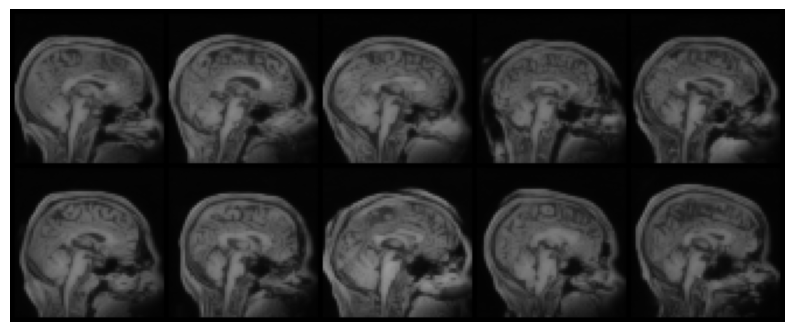

In [5]:
# plotted 10 random images of 15k generated images from my google drive file
train_samples = np.load('/content/drive/MyDrive/brain_dataset/15k_images.npy')

random_indices = np.random.choice(train_samples.shape[0], size=10, replace=False)
train_random_samples = train_samples[random_indices]
train_samples_tensor = torch.tensor(train_random_samples, dtype=torch.float32)

grid = make_grid(train_samples_tensor, nrow=5, padding=2).permute(1, 2, 0)
plt.figure(figsize=(10, 5))
plt.imshow(grid, cmap='gray')
plt.axis('off')
plt.show()


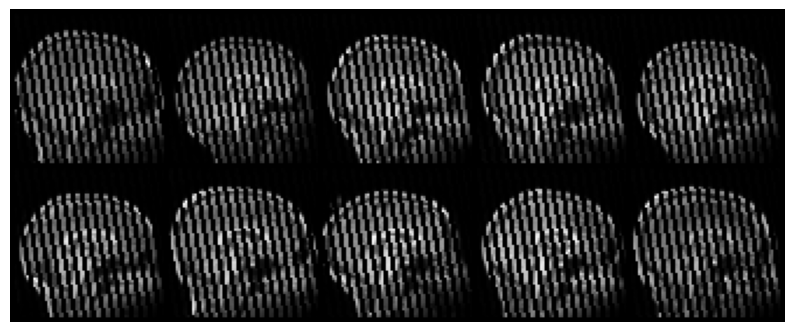

In [7]:
# Plotted  10 random images of 100 corrupted images in test_set.npy
test_images = np.load('test_set.npy')

random_indices = np.random.choice(test_images.shape[0], size=10, replace=False)
samples = test_images[random_indices]

grid = make_grid(torch.tensor(samples), nrow=5, padding=2).permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.imshow(grid, cmap='gray')
plt.axis('off')
plt.show()

<br>

---

<br>

## **Question 2**  (25%)

Using the data generated in **Question 1**, create a PyTorch `TensorDataset` and a `DataLoader` for the training set.

Using the provided corrupted images inside `test_set.npy`, create another `TensorDataset` and a `DataLoader` for the test set.

The training dataset should provide batches of brain images generated in **Question 1** and should corrupt these images appropriately so that they resemble images in the test set. The dataset should also pair each image with its corresponding un-corrupted image as a label.

The test dataset should provide the corrupted images provided, for which no labels are available.

Display here ten images of your training dataset and ten images of your test dataset, and their corresponding labels when available.

<br>



---
**Question 2**:
Now, let’s try to imitate the masks in the test set and apply them to the training dataset. Among the 100 images, there are 39 different masks; however, each mask changes by only 2 pixels. Instead of randomly selecting one of the 39 masks for each image, I opted to take the mean mask and apply it to each image in the training dataset.

In [8]:
mean_mask = np.zeros(test_images[0].shape[1:], dtype=np.float32)

threshold = 0.1

for img in test_images:
    img = img.squeeze()
    # boolean mask for each pixel, True if greater than threshold
    valid_pixels = (img > threshold)
    mean_mask += valid_pixels

mean_mask[mean_mask > 0] = 1
# inverted as it plotted the opposite of what i wanted
mean_mask = 1 - mean_mask

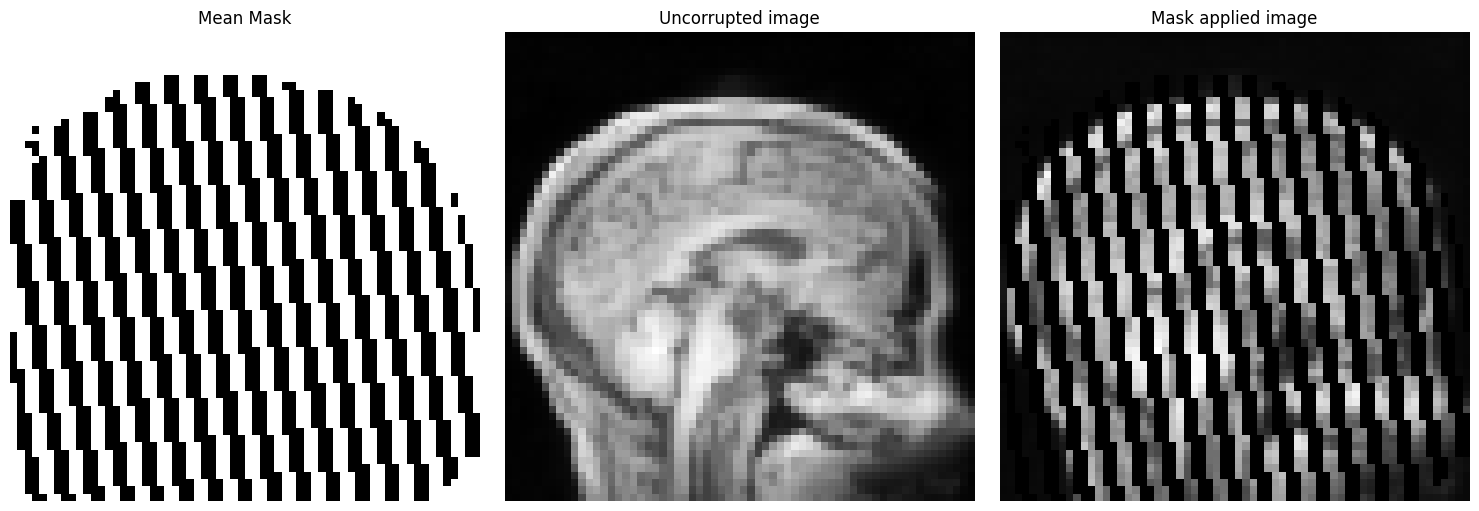

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(mean_mask, cmap='gray')
axes[0].set_title("Mean Mask")
axes[0].axis('off')

axes[1].imshow(train_samples[0].squeeze(),cmap='grey')
axes[1].set_title("Uncorrupted image")
axes[1].axis('off')

axes[2].imshow(train_samples[0].squeeze() * mean_mask,cmap='grey')
axes[2].set_title("Mask applied image")
axes[2].axis('off')

plt.tight_layout()
plt.show()

Now that we have our mean mask, we can create a dataset. I chose to create a class that subclasses Dataset instead of using TensorDataset, as I felt more comfortable with this approach. We will also set up our DataLoader.

In [10]:
class TrainDataset(Dataset):
    def __init__(self, file_path, mean_mask, transform=None):
        self.file_path = file_path
        self.data = self._load_file()
        self.transform = transform
        self.mean_mask = mean_mask

    def _load_file(self):
        return np.load(self.file_path)

    def _get_mask(self, sample):
        masked_sample = sample * self.mean_mask

        # changed all the white pixels to black
        masked_sample[masked_sample >= 1.0] = 0

        return masked_sample

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample[0]

        if self.transform:
            transformed = self.transform(image)
            image = transformed

        masked_sample = self._get_mask(transformed if self.transform else sample)

        return masked_sample, image

    def __len__(self):
        return len(self.data)

In [11]:
# During hyperparatuning process, it tried Data Augmentation, but it did not result in a better loss

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5]),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
])


train_dataset = TrainDataset(file_path='/content/drive/MyDrive/brain_dataset/15k_images.npy', mean_mask=mean_mask, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Similarly, I created a dataset and DataLoader for my test set.

In [12]:
class TestDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.data = self._load_file()
        self.transform = transform

    def _load_file(self):
      return np.load(self.file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = torch.tensor(image, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image

In [13]:
transform = transforms.Compose([
     transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5]),
])
test_dataset = TestDataset(file_path='test_set.npy', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

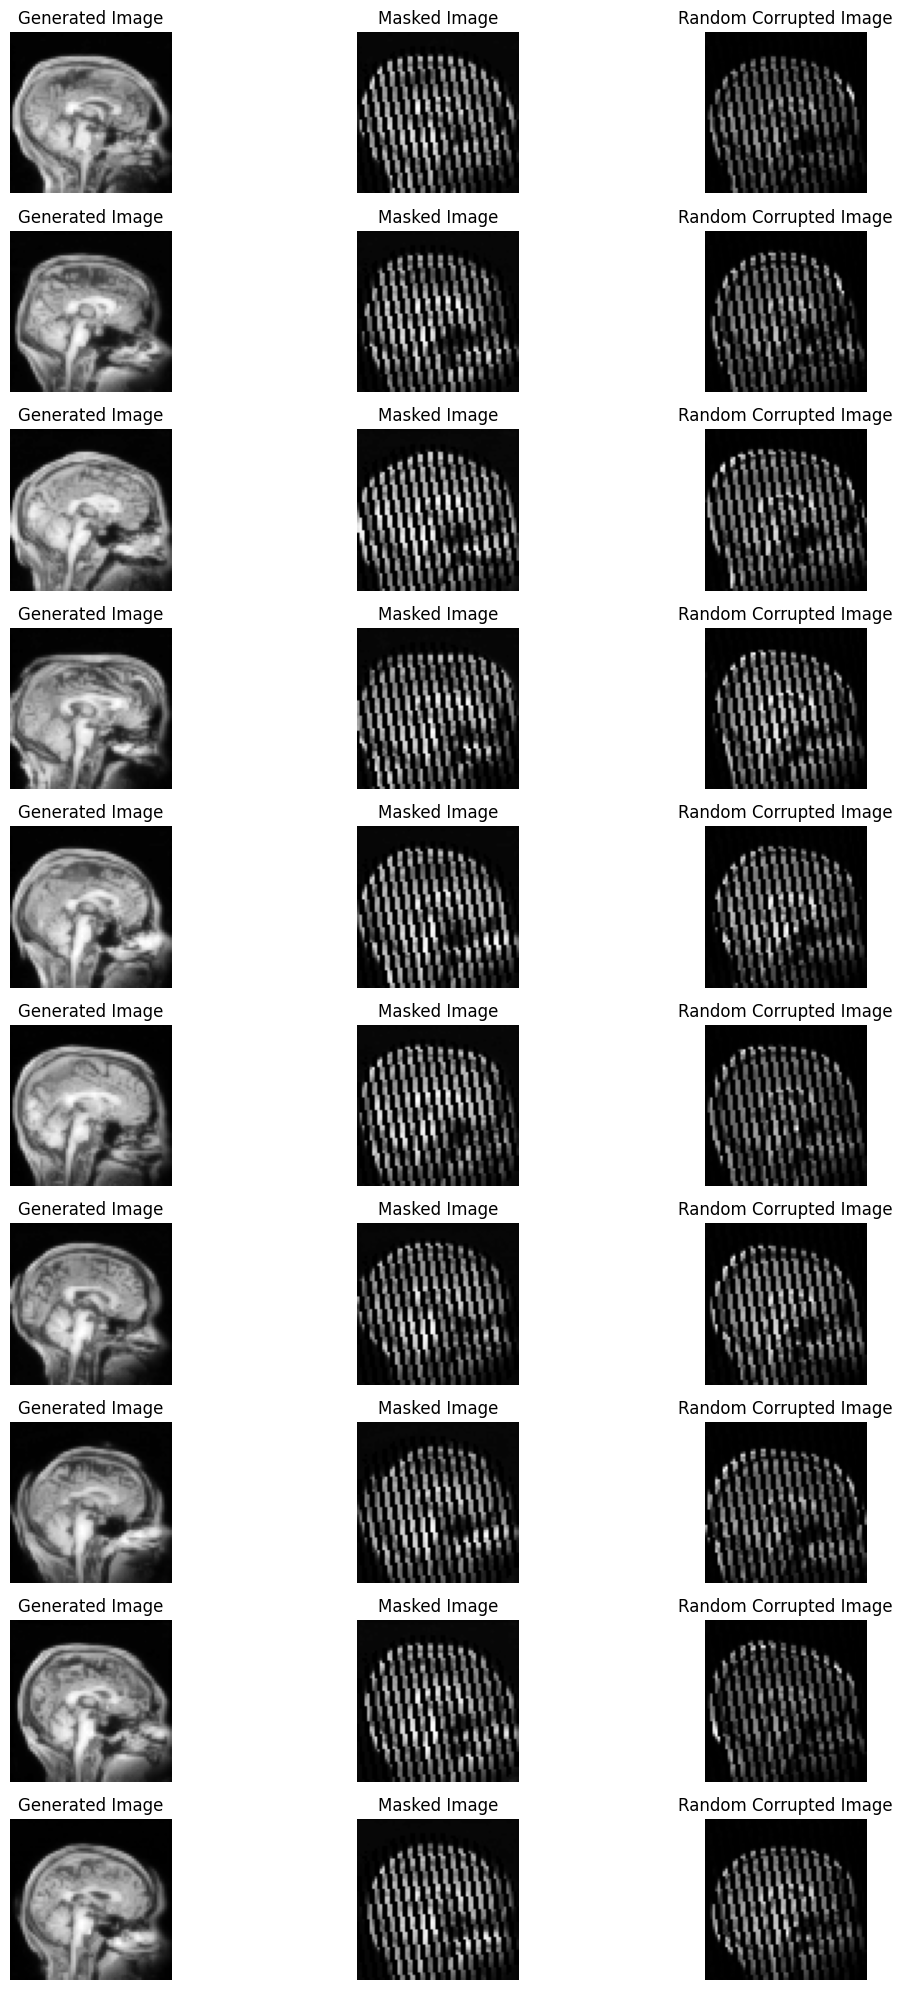

In [14]:
masked_images , generated_images = next(iter(train_loader))
corrupted_images = next(iter(test_loader))

fig, axes = plt.subplots(10, 3, figsize=(12, 2 * 10))

for i in range(10):
    axes[i, 0].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[i, 0].set_title('Generated Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masked_images[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('Masked Image')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(corrupted_images[i].squeeze(), cmap='gray')
    axes[i, 2].set_title('Random Corrupted Image')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

<br>

---

<br>

## **Question 3** (50%)

Using the dataset created in **Question 2**, design and train an architecture to recover the missing image lines of the provided test dataset.

Once you have trained your architecture, display here ten images of the test set with the recovered lines filled in.

Additionally, save the test data with the missing values filled in into a numpy file called `test_set_nogaps.npy`. These images should be **in the same order** as those in the `test_set.npy` file and should have the same pixel size of 64x64. **Any images not contained in the `test_set_nogaps.npy` file or incorrectly ordered will not be marked.**

You have freedom to choose an architecture that you consider appropriate to solve this problem. However, you will need to train your chosen architecture as part of the assessment: **pre-trained networks are not allowed**.

You will be assessed by the quality of your predictions of the missing data values and additional marks will be given for originality in your network design choices. You should include, as part of your answer, a paragraph explaining the architecture you have chosen and any additional design choices and hyperparameters that have been important to build your solution.

This is an open-book assessment and you are encouraged to use resources online, including  tools like chatGPT. However, make sure to always mention the sources for your code and ideas, including websites, papers, and tools like chatGPT.

<br>


<br>

---

<br>

---
**Question 3**:

First of all, I splited my training loader into a training loader and a validation loader using an 80-20 split, which resulted in 12,000 samples for training and 3,000 for validation.

Now, let’s discuss the architecture. An image inpainting task can be implemented in various ways. I started with a simple CNN that had a few layers and a basic structure, but I was unable to make it overfit after running it for one epoch.

Consequently, [1] I implemented a U-Net architecture, and I immediately noticed a significant improvement. I will delve into more details as we progress

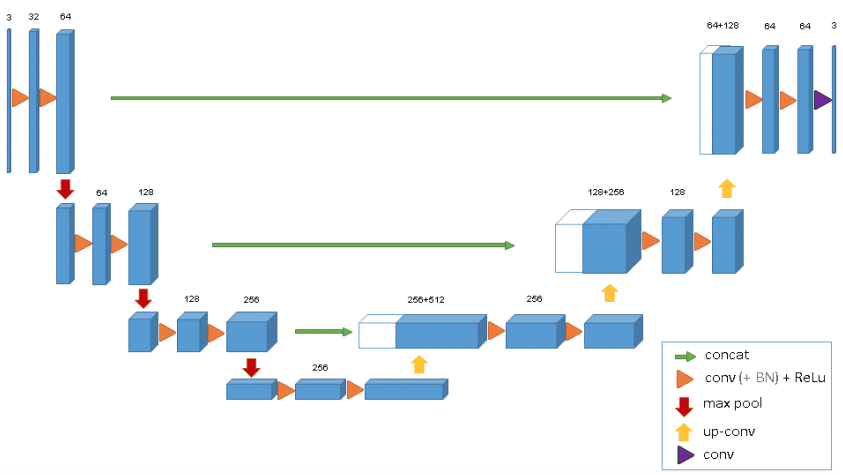

In [15]:
from torch.utils.data import random_split, DataLoader

train_dataset = train_loader.dataset
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=train_loader.batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=train_loader.batch_size, shuffle=False)

print(f"New Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}")


New Train size: 12000, Validation size: 3000


U-Net is a convolutional neural network (CNN) architecture, which is effective for image inpainting tasks [1]. It consists of several key components:

1.   Encoder:

The encoder uses convolution for down-sampling the input image. In our case, we used 4 'conv_blocks', where each block has two convolutional layers followed by a ReLU activation function. The first layer of the first blockakes an input channel of one (black and white image)

2.   Bottleneck: [2]

The bottleneck "are a way to force the model to learn a compression of the input data", representing the lowest spatial resolution. Here it is formed by 1 'conv_block'

3. Decoder:

In contrast to the encoder, it gradually upsamples the feature maps, it is usaully a common practice to build the decoder inversely proportionally to the encoder.

4. Skip Connections

The skip connection simply concats feature maps from the encoder to the decoder at each level. This process provides additional granularity for gradients to flow during backpropagation.








In [16]:
class UNet(nn.Module):
    def __init__(self):
        # encoder (4 conv block)
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # bottleneck (1 conv block)
        self.bottleneck = self.conv_block(512, 1024)

        # decoder (4 conv block)
        self.dec4 = self.conv_block(1024 + 512, 512)
        self.dec3 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)


    # 2 Conv2d + ReLU
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    # through iteration added Maxpool2d, controls overfitting
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(nn.MaxPool2d(2)(e1))
        e3 = self.enc3(nn.MaxPool2d(2)(e2))
        e4 = self.enc4(nn.MaxPool2d(2)(e3))

        b = self.bottleneck(nn.MaxPool2d(2)(e4))

        d4 = self.dec4(torch.cat([nn.Upsample(scale_factor=2)(b), e4], dim=1))
        d3 = self.dec3(torch.cat([nn.Upsample(scale_factor=2)(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([nn.Upsample(scale_factor=2)(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([nn.Upsample(scale_factor=2)(d2), e1], dim=1))

        # Output
        return self.final(d1)


In [17]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)

In [18]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    return val_loss / len(val_loader)


In [19]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,0.001)
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


This step was crucial in optimizing the model's performance, and I explored several hyperparameters through a systematic trial-and-error approach,initially using a subset of just 1,000 points generated from the dataset instead of the full 12,000 points. This smaller dataset allowed for quicker experimentation:

*   Activation Functions: I experimented with various activation functions, including Mish and GELU; however, ReLU consistently yielded the best loss performance. (More details on the choice of the loss function will follow.)

*   The architecture's depth significantly influenced the final model's effectiveness, and I evaluated different configurations to determine the optimal number of layers. [3]

* I used Mean Squared Error (MSE) [5] to calculate the loss because it directly measures pixel-by-pixel reconstruction accuracy. It penalizes larger errors more heavily, making it ideal for image rescontruction.

*  I carefully tuned the learning rate and weight decay, ending up with the weight decay to the default value. Additionally, I adjusted the number of epochs, padding, and input/output channels (using powers of 2) to optimize training. [4]

* I implemented data augmentation techniques, but they unfortunately worsened the loss

* I opted for the Adam  optimizer due to its adaptive learning rate properties and effectiveness in training deep learning models (Adam is always the right answer :).



In [352]:
unet_model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)

num_epochs = 20
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss = train_model(unet_model, train_loader, criterion, optimizer, device)
    val_loss = validate_model(unet_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}")


Epoch 1/20, Train Loss: 0.148828, Validation Loss: 0.000946
Epoch 2/20, Train Loss: 0.000685, Validation Loss: 0.000548
Epoch 3/20, Train Loss: 0.000504, Validation Loss: 0.000469
Epoch 4/20, Train Loss: 0.000443, Validation Loss: 0.000416
Epoch 5/20, Train Loss: 0.000405, Validation Loss: 0.000383
Epoch 6/20, Train Loss: 0.000380, Validation Loss: 0.000376
Epoch 7/20, Train Loss: 0.000361, Validation Loss: 0.000347
Epoch 8/20, Train Loss: 0.000347, Validation Loss: 0.000337
Epoch 9/20, Train Loss: 0.000336, Validation Loss: 0.000326
Epoch 10/20, Train Loss: 0.000326, Validation Loss: 0.000362
Epoch 11/20, Train Loss: 0.000317, Validation Loss: 0.000324
Epoch 12/20, Train Loss: 0.000313, Validation Loss: 0.000305
Epoch 13/20, Train Loss: 0.000304, Validation Loss: 0.000301
Epoch 14/20, Train Loss: 0.000299, Validation Loss: 0.000297
Epoch 15/20, Train Loss: 0.000293, Validation Loss: 0.000292
Epoch 16/20, Train Loss: 0.000288, Validation Loss: 0.000292
Epoch 17/20, Train Loss: 0.000286

After 20 epochs, both the training loss and validation loss converged around 0.0003, which is a relatively low score. Given that both losses are low and converging, this suggests that the model may not be overfitting.

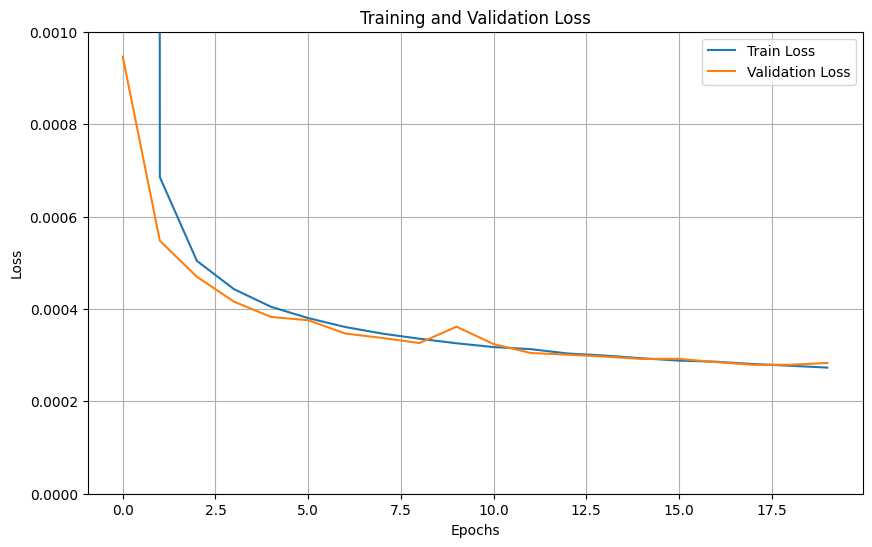

In [355]:
plot_losses(train_losses, val_losses)

In [354]:
# Saved the model
model_save_path = '/content/drive/MyDrive/final_unet_v3.pth'
torch.save(unet_model.state_dict(), model_save_path)

In [20]:
# For this vizualiation, i asked chatGPT to help me as i way getting error regarding the index, and using subplots
# i could not find the session, hence the reason it is not on references.md
def plot_test_results_organized(model, test_loader, device, num_images=10):
    model.eval()
    images = []
    predictions = []

    with torch.no_grad():
        for corrupted_images in test_loader:
            corrupted_images = corrupted_images.to(device)
            preds = model(corrupted_images)
            images.extend(corrupted_images.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            if len(images) >= num_images:
                break

    images = images[:num_images]
    predictions = predictions[:num_images]

    plt.figure(figsize=(15, 10))

    for i in range(5):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title("Corrupted")
        plt.axis("off")

        plt.subplot(4, 5, i + 6)
        plt.imshow(predictions[i][0], cmap='gray')
        plt.title("Reconstruction")
        plt.axis("off")

    for i in range(5, 10):
        plt.subplot(4, 5, (i - 5) + 11)
        plt.imshow(images[i][0], cmap='gray')
        plt.title("Corrupted")
        plt.axis("off")

        plt.subplot(4, 5, (i - 5) + 16)
        plt.imshow(predictions[i][0], cmap='gray')
        plt.title("Reconstruction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Upon examining the images, it is clear that there is no mode collapse, as the predicted/imputed images maintain distinct skull structures compared to the input images. This indicates that the model does not simply take the mean of the inputs, which corroborates with the absence of overffiting above

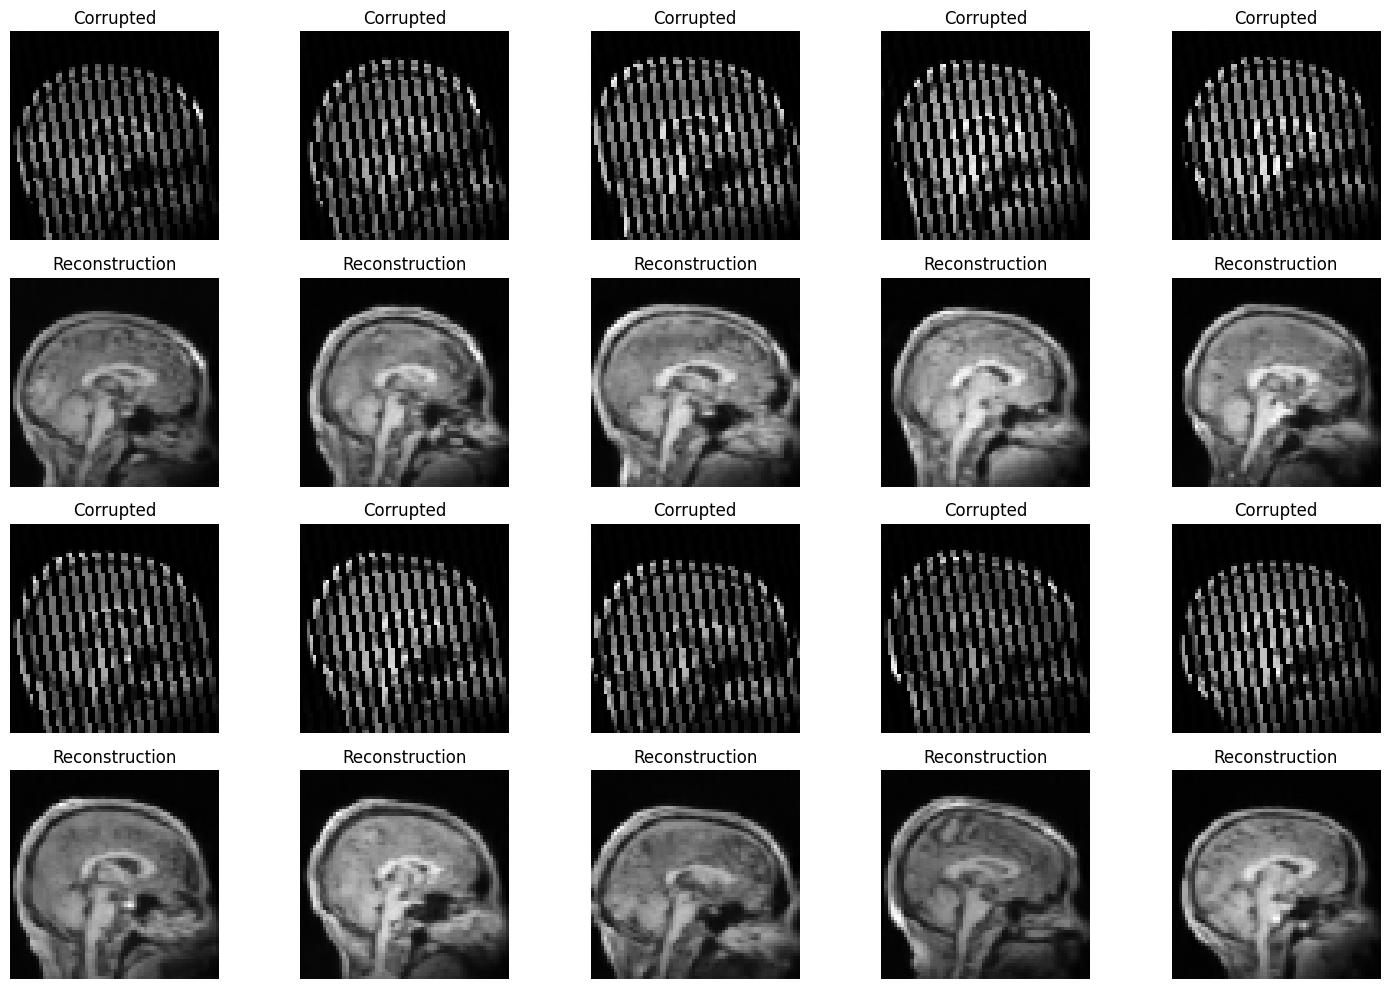

In [373]:
plot_test_results_organized(unet_model, test_loader, device, num_images=10)

Here is an example of how I would load my trained model from my drive and plot the function above, showcasing the predictions:

In [22]:
model = UNet().to(device)  # Initialize your model
model.load_state_dict(torch.load('/content/drive/MyDrive/final_unet_v3.pth'))
# plot_test_results_organized(model, test_loader, device, num_images=10)

<ipython-input-22-e24af955ca9c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/final_unet_v3.pth'))


<All keys matched successfully>

In [23]:
model.eval()
corrupted_images = np.load('test_set.npy')

imputed_images = []

with torch.no_grad():
    for img in corrupted_images:
        img = torch.tensor(img).float().unsqueeze(0).to(device)
        imputed_img = model(img)

        imputed_images.append(imputed_img.cpu().numpy().squeeze(0))

imputed_images = np.array(imputed_images)

output_path = '/content/drive/My Drive/test_set_nogaps.npy'
np.save(output_path, imputed_images)

print(f"Imputed images saved to '{output_path}'.")


Imputed images saved to '/content/drive/My Drive/test_set_nogaps.npy'.


This demonstrates that the order is well respected, as we can see that the test data matchesthe predictions, particularly in terms of the dimensions and structure of the skulls.

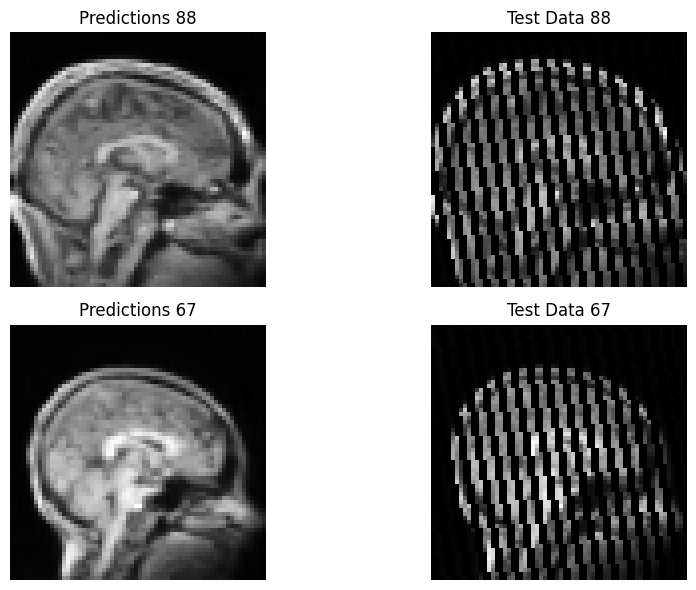

In [30]:
test_data = np.load(output_path)

random_indices = np.random.choice(range(100), size=2, replace=False)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].imshow(test_data[random_indices[0]].squeeze(), cmap='grey')
axs[0, 0].set_title(f'Predictions {random_indices[0]}')
axs[0, 0].axis('off')

axs[1, 0].imshow(test_data[random_indices[1]].squeeze(), cmap='grey')
axs[1, 0].set_title(f'Predictions {random_indices[1]}')
axs[1, 0].axis('off')

axs[0, 1].imshow(corrupted_images[random_indices[0]].squeeze(), cmap='grey')
axs[0, 1].set_title(f'Test Data {random_indices[0]}')
axs[0, 1].axis('off')

axs[1, 1].imshow(corrupted_images[random_indices[1]].squeeze(), cmap='grey')
axs[1, 1].set_title(f'Test Data {random_indices[1]}')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

Finally, this plot illustrates the comparison between the masked image, the reconstructed image generated by the model, and the original image, (using the validation data set) highlighting the model's effectiveness in image inpainting.

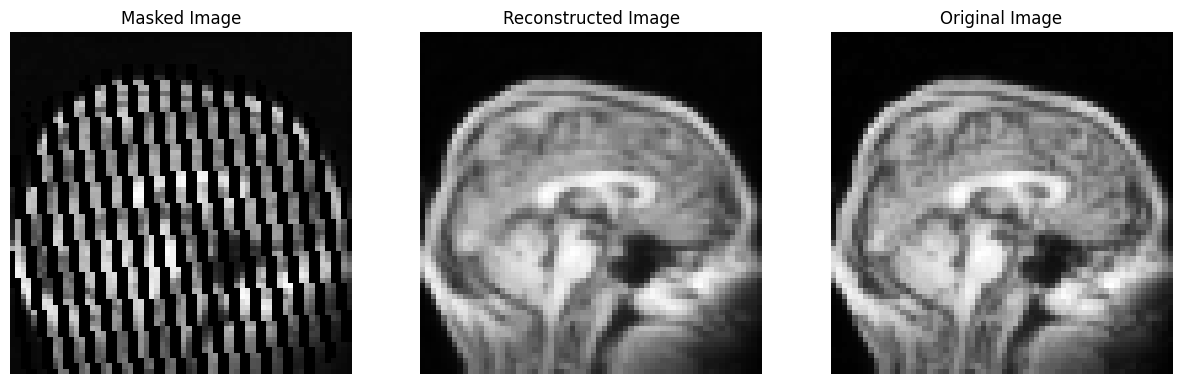

In [31]:
masked_images, original_images = next(iter(val_loader))
masked_image = masked_images[22].squeeze()
original_image = original_images[22].squeeze()
model.eval()
with torch.no_grad():
    masked_image_tensor = masked_image.unsqueeze(0).unsqueeze(0).to(device)
    reconstructed_image_tensor = model(masked_image_tensor)
    reconstructed_image = reconstructed_image_tensor.cpu().numpy().squeeze(0)

reconstructed_image = reconstructed_image.squeeze()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Masked Image')
plt.imshow(masked_image.numpy(), cmap='gray')
plt.axis('off')


plt.subplot(1, 3, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.title('Original Image')
plt.imshow(original_image.numpy(), cmap='gray')
plt.axis('off')

plt.show()
